# SO MANY TS DIAGRAMS

the adventures of whether or not they'll be an obvious way to distinguish my water masses

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.interpolate import interpn
import scipy.interpolate as interp
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from scipy.stats import binned_statistic_2d

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [3]:
def get_data(mydata, starttime, endtime):
    salt = mydata.init_salt[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    temp = mydata.init_temp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
#     depth = depthf(mydata.init_z[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    trans = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(endtime-starttime+1)
    return salt, temp, trans

def get_allll_data(mydata, starttime, endtime):
    salt = mydata.init_salt[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    temp = mydata.init_temp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    depth = depthf(mydata.init_z[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    lon = mydata.init_lon[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    trans = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(endtime-starttime+1)
    return salt, temp, depth, lon, trans

In [4]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(len(t_depths)-1):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', zorder=3)
    return(pc)

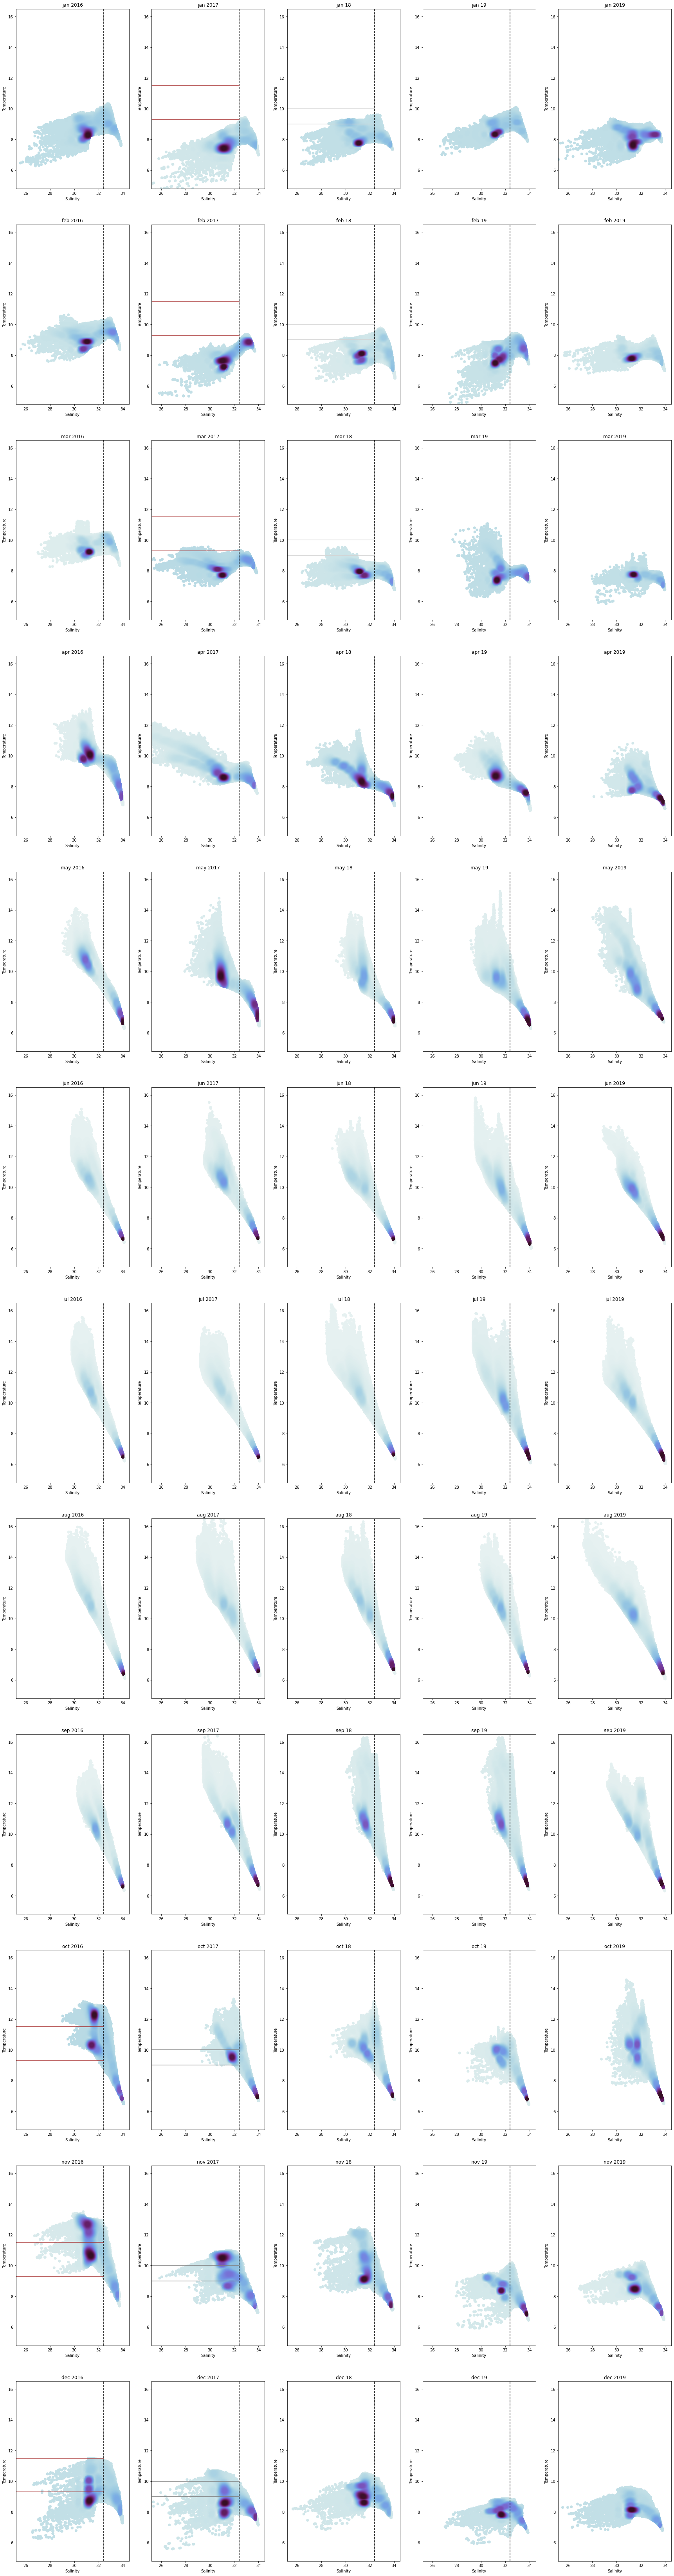

In [9]:
fig, ax = plt.subplots(12,5, figsize=(30,120))

yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
starttime = 1
endtime = 720

#2016 and 2017
year = [16,17]

l = -1
for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    k=0
    l+=1
    for i in range(12):
        salt, temp, _ = get_data(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
        
        #would like to get the denisty of points
        data , x_e, y_e = np.histogram2d(salt,temp, bins = 20, density = True )
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
        z[np.where(np.isnan(z))] = 0.0

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        salt, temp, z = salt[idx], temp[idx], z[idx]
                    
        ax[k,l].scatter(salt,temp, c=z, cmap=cm.cm.dense)
        ax[k,l].plot([32.4, 32.4], [4.8,16.5], 'k--')
        title = str_mo[i] + " 20" + str(num)
        ax[k,l].set_title(title)
        ax[k,l].set_ylabel('Temperature')
        ax[k,l].set_xlabel('Salinity')
        ax[k,l].set_ylim([4.8, 16.5])
        ax[k,l].set_xlim([25.2, 34.5])
        
        if num == 16 and i >= 9:
            ax[k,l].plot([25.2, 32.4], [11.5,11.5], color='brown')
            ax[k,l].plot([25.2, 32.4], [9.3,9.3], color='brown')
        if num == 17 and i <= 2:
            ax[k,l].plot([25.2, 32.4], [11.5,11.5], color='brown')
            ax[k,l].plot([25.2, 32.4], [9.3,9.3], color='brown')
        if num == 17 and i >=9:
            ax[k,l].plot([25.2, 32.4], [10,10], color='grey')
            ax[k,l].plot([25.2, 32.4], [9,9], color='grey')
        k+=1

#2019 and 2018 (both done month by month)
year = [18,19]
l=1
k=0
for num in year:
    l+=1
    k=0
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        
        salt = mydata.init_salt
        temp = mydata.init_temp
        
        data , x_e, y_e = np.histogram2d(salt,temp, bins = 20, density = True )
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
        z[np.where(np.isnan(z))] = 0.0
        idx = z.argsort()
        salt, temp, z = salt[idx], temp[idx], z[idx]
        
        ax[k,l].scatter(salt,temp, c=z, cmap=cm.cm.dense)
        ax[k,l].plot([32.4, 32.4], [4.8,16.5], 'k--')
        
        if num == 18 and i <= 2:
            ax[k,l].plot([25.2, 32.4], [10,10], color='lightgrey')
            ax[k,l].plot([25.2, 32.4], [9,9], color='lightgrey')
        
        title = str_mo[i] + " " + str(num)
        ax[k,l].set_title(title)
        ax[k,l].set_ylabel('Temperature')
        ax[k,l].set_xlabel('Salinity')
        ax[k,l].set_ylim([4.8, 16.5])
        ax[k,l].set_xlim([25.2, 34.5])
        k+=1
            

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

l=4
k=0
for i in range(12):
        salt, temp, _ = get_data(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
        
        data , x_e, y_e = np.histogram2d(salt,temp, bins = 20, density = True )
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
        z[np.where(np.isnan(z))] = 0.0

        idx = z.argsort()
        salt, temp, z = salt[idx], temp[idx], z[idx]
                    
        ax[k,l].scatter(salt,temp, c=z, cmap=cm.cm.dense)
        title = str_mo[i] + " 20" + str(num)
        ax[k,l].set_title(title)
        ax[k,l].set_ylabel('Temperature')
        ax[k,l].set_xlabel('Salinity')
        ax[k,l].set_ylim([4.8, 16.5])
        ax[k,l].set_xlim([25.2, 34.5])
        k+=1

# CIOPS TS match?

In [5]:
mymesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [6]:
mon16 = ['oct16', 'nov16', 'dec16', 'jan17', 'feb17', 'mar17']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

monS = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
mon_len = [30, 31, 30, 31, 31, 30]
sum_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
sum_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

mon17 = ['oct17', 'nov17', 'dec17', 'jan18', 'feb18', 'mar18'] 

(25.2, 34.5)

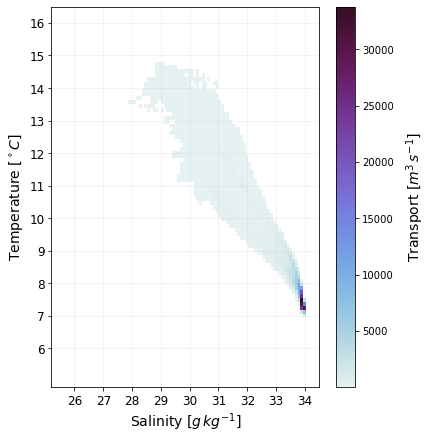

In [15]:
# just summer (june, july, august, september) in one TS diagram
fig, ax = plt.subplots(1,1, figsize=(6,7))
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt, temp, trans = get_data(mydata, sum_start[2], sum_end[-1])

bins = [np.linspace(25.2,34.6,100),np.linspace(4.8,16.6,100)]
H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X, Y, H_final, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax.set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax.set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax.set_yticks(np.arange(6,17,1))
ax.set_yticklabels(np.arange(6,17,1),fontsize=12)
ax.set_xticks(np.arange(26,35,1))
ax.set_xticklabels(np.arange(26,35,1),fontsize=12)
ax.grid(color='gray',alpha=0.1)
ax.set_ylim([4.8, 16.5])
ax.set_xlim([25.2, 34.5])

(25.2, 34.5)

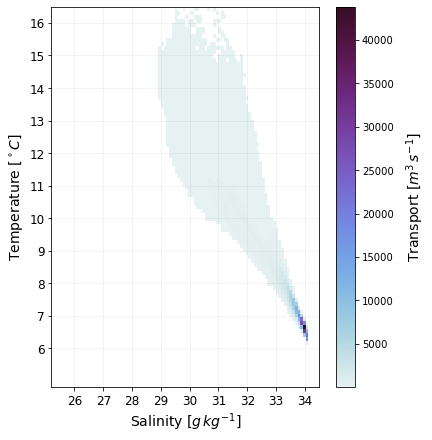

In [17]:
# summer SSC in one TS diagram
# 2017
fig, ax = plt.subplots(1,1, figsize=(6,7))
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
ssc_sum_start = 1+(5*720+(sum(yearjumps[:5+1]*24)))
ssc_sum_end = 720+(8*720+(sum(yearjumps[:8+1]*24)))

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt = mydata.init_salt[(mydata.init_t >= ssc_sum_start) & (mydata.init_t <= ssc_sum_end)]
temp = mydata.init_temp[(mydata.init_t >= ssc_sum_start) & (mydata.init_t <= ssc_sum_end)]
starttime = ssc_sum_start
endtime = ssc_sum_end
trans = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(endtime-starttime+1)

bins = [np.linspace(25.2,34.6,100),np.linspace(4.8,16.6,100)]

H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X, Y, H_final, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax.set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax.set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax.set_yticks(np.arange(6,17,1))
ax.set_yticklabels(np.arange(6,17,1),fontsize=12)
ax.set_xticks(np.arange(26,35,1))
ax.set_xticklabels(np.arange(26,35,1),fontsize=12)
ax.grid(color='gray',alpha=0.1)
ax.set_ylim([4.8, 16.5])
ax.set_xlim([25.2, 34.5])

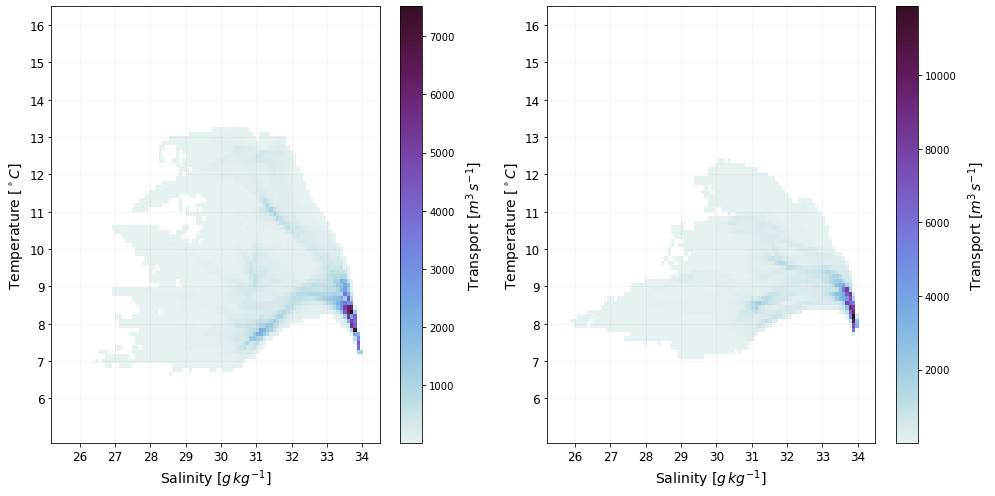

In [18]:
# winters seperately
fig, ax = plt.subplots(1,2, figsize=(14,7))

time = win_end[-1] - win_start[0] + 1 + sum_end[1] - sum_start[0] + 1

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltW16 = mydata.init_salt[(mydata.init_t >= win_start[0]) & (mydata.init_t <= win_end[-1])]
tempW16 = mydata.init_temp[(mydata.init_t >= win_start[0]) & (mydata.init_t <= win_end[-1])]
endtime, starttime = win_end[-1], win_start[0]
transW16 = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/time

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltS = mydata.init_salt[(mydata.init_t >= sum_start[0]) & (mydata.init_t <= sum_end[1])]
tempS = mydata.init_temp[(mydata.init_t >= sum_start[0]) & (mydata.init_t <= sum_end[1])]
endtime, starttime = sum_end[1], sum_start[0]
transS = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/time

salt = np.append(saltW16, saltS)
temp = np.append(tempW16, tempS)
trans = np.append(transW16, transS)

bins = [np.linspace(25.2,34.6,100),np.linspace(4.8,16.6,100)]
        
H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0].pcolormesh(X, Y, H_final, cmap=cmap)
cb = fig.colorbar(im, ax=ax[0])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax[0].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[0].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[0].set_yticks(np.arange(6,17,1))
ax[0].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[0].set_xticks(np.arange(26,35,1))
ax[0].set_xticklabels(np.arange(26,35,1),fontsize=12)
ax[0].grid(color='gray',alpha=0.1)
ax[0].set_ylim([4.8, 16.5])
ax[0].set_xlim([25.2, 34.5])

# all winter 2017/18
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt = mydata.init_salt[(mydata.init_t >= win_start[0]) & (mydata.init_t <= win_end[-1])]
temp = mydata.init_temp[(mydata.init_t >= win_start[0]) & (mydata.init_t <= win_end[-1])]

endtime, starttime = win_end[-1], win_start[0]
time = endtime-starttime+1
trans = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/time

H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[1].pcolormesh(X, Y, H_final, cmap=cmap)
cb = fig.colorbar(im, ax=ax[1])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax[1].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[1].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[1].set_yticks(np.arange(6,17,1))
ax[1].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[1].set_xticks(np.arange(26,35,1))
ax[1].set_xticklabels(np.arange(26,35,1),fontsize=12)
ax[1].grid(color='gray',alpha=0.1)
ax[1].set_ylim([4.8, 16.5])
ax[1].set_xlim([25.2, 34.5])

plt.tight_layout()

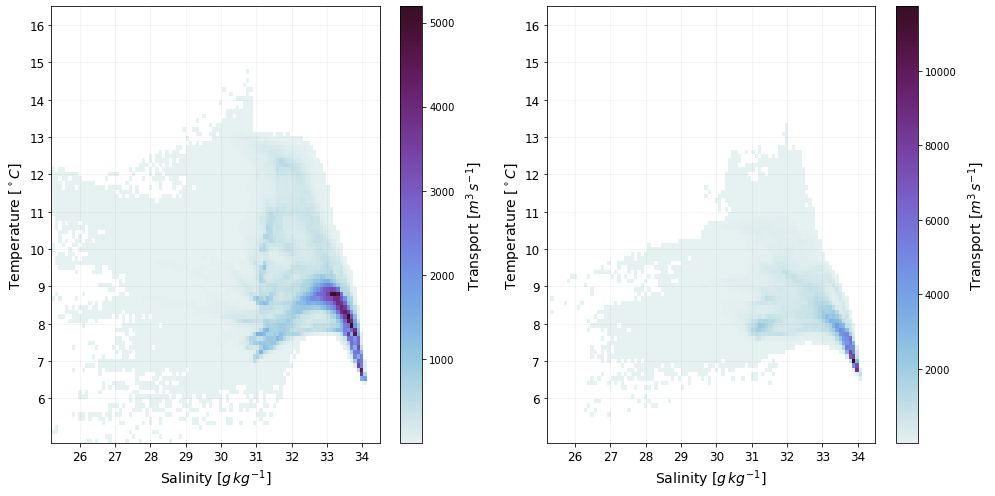

In [19]:
### SSC winters
fig, ax = plt.subplots(1,2, figsize=(14,7))

# 2016/17

yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
ssc_win_start = 1+(9*720+(sum(yearjumps[:9+1]*24)))
ssc_win_end = 720+(11*720+(sum(yearjumps[:11+1]*24)))

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltW16 = mydata.init_salt[(mydata.init_t >= ssc_win_start) & (mydata.init_t <= ssc_win_end)]
tempW16 = mydata.init_temp[(mydata.init_t >= ssc_win_start) & (mydata.init_t <= ssc_win_end)]
starttime = ssc_win_start
endtime = ssc_win_end
transW16 = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/time

ssc_win_start = 1+(0*720+(sum(yearjumps[:0+1]*24)))
ssc_win_end = 720+(4*720+(sum(yearjumps[:4+1]*24)))

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltS = mydata.init_salt[(mydata.init_t >= ssc_win_start) & (mydata.init_t <= ssc_win_end)]
tempS = mydata.init_temp[(mydata.init_t >= ssc_win_start) & (mydata.init_t <= ssc_win_end)]
starttime = ssc_win_start
endtime = ssc_win_end
transS = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/time

salt = np.append(saltW16, saltS)
temp = np.append(tempW16, tempS)
trans = np.append(transW16, transS)

bins = [np.linspace(25.2,34.6,100),np.linspace(4.8,16.6,100)]

H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0].pcolormesh(X, Y, H_final, cmap=cmap)
cb = fig.colorbar(im, ax=ax[0])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax[0].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[0].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[0].set_yticks(np.arange(6,17,1))
ax[0].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[0].set_xticks(np.arange(26,35,1))
ax[0].set_xticklabels(np.arange(26,35,1),fontsize=12)
ax[0].grid(color='gray',alpha=0.1)
ax[0].set_ylim([4.8, 16.5])
ax[0].set_xlim([25.2, 34.5])

# 2017/18
# SSC same period
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
ssc_win_start = 1+(9*720+(sum(yearjumps[:9+1]*24)))
ssc_win_end = 720+(11*720+(sum(yearjumps[:11+1]*24)))
time = ssc_win_end - ssc_win_start + 1 + 720*3

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt17 = mydata.init_salt[(mydata.init_t >= ssc_win_start) & (mydata.init_t <= ssc_win_end)]
temp17 = mydata.init_temp[(mydata.init_t >= ssc_win_start) & (mydata.init_t <= ssc_win_end)]
starttime = ssc_win_start
endtime = ssc_win_end
trans17 = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/time

start = 1
end = 720

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_jan = mydata.init_salt[(mydata.init_t >= start) & (mydata.init_t <= end)]
temp_jan = mydata.init_temp[(mydata.init_t >= start) & (mydata.init_t <= end)]
trans_jan = mydata.init_transp[(mydata.init_t >= start) & (mydata.init_t <= end)]/time

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01feb18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_feb = mydata.init_salt[(mydata.init_t >= start) & (mydata.init_t <= end)]
temp_feb = mydata.init_temp[(mydata.init_t >= start) & (mydata.init_t <= end)]
trans_feb = mydata.init_transp[(mydata.init_t >= start) & (mydata.init_t <= end)]/time

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01mar18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_mar = mydata.init_salt[(mydata.init_t >= start) & (mydata.init_t <= end)]
temp_mar = mydata.init_temp[(mydata.init_t >= start) & (mydata.init_t <= end)]
trans_mar = mydata.init_transp[(mydata.init_t >= start) & (mydata.init_t <= end)]/time

salt = np.append(np.append(np.append(salt17, salt_jan), salt_feb), salt_mar)
temp = np.append(np.append(np.append(temp17, temp_jan), temp_feb), temp_mar)
trans = np.append(np.append(np.append(trans17, trans_jan), trans_feb), trans_mar)

H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)#,norm=LogNorm())
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[1].pcolormesh(X, Y, H_final, cmap=cmap)
cb = fig.colorbar(im, ax=ax[1])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)
ax[1].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[1].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
ax[1].set_yticks(np.arange(6,17,1))
ax[1].set_yticklabels(np.arange(6,17,1),fontsize=12)
ax[1].set_xticks(np.arange(26,35,1))
ax[1].set_xticklabels(np.arange(26,35,1),fontsize=12)
ax[1].grid(color='gray',alpha=0.1)
ax[1].set_ylim([4.8, 16.5])
ax[1].set_xlim([25.2, 34.5])

plt.tight_layout()

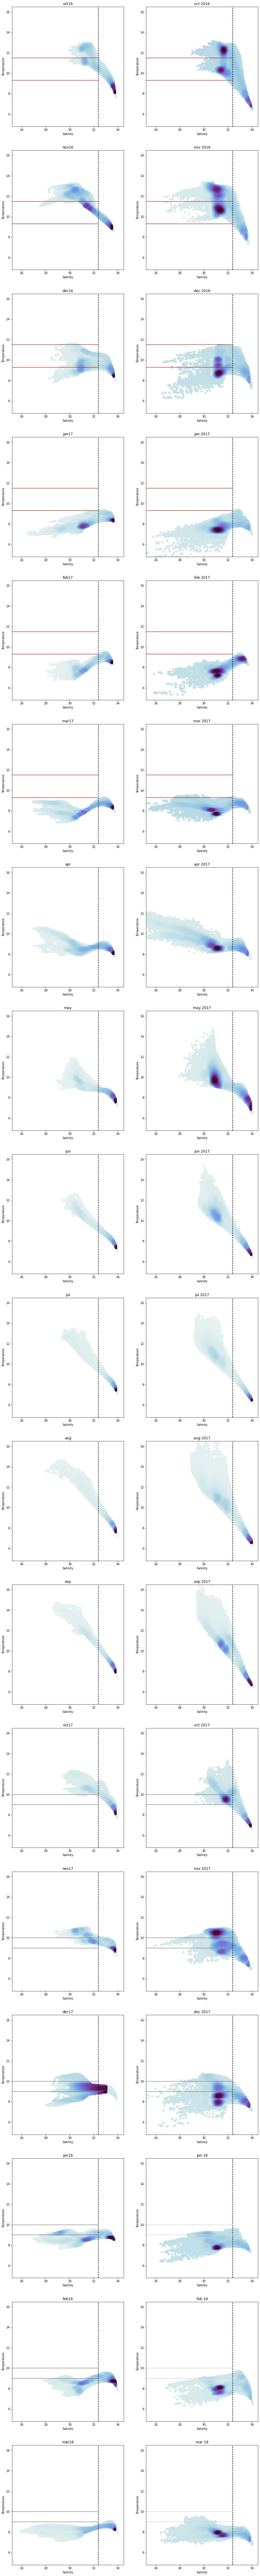

In [27]:
fig, ax = plt.subplots(18,2, figsize=(15,160))

# CIOPS
# winter 2016/17
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

k=0
for i in range(len(mon_len)):
        salt, temp, _ = get_data(mydata, win_start[i], win_end[i])
        
        #would like to get the denisty of points
        data , x_e, y_e = np.histogram2d(salt,temp, bins = 20, density = True )
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
        z[np.where(np.isnan(z))] = 0.0

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        salt, temp, z = salt[idx], temp[idx], z[idx]
                    
        ax[k,0].scatter(salt,temp, c=z, cmap=cm.cm.dense)
        ax[k,0].plot([32.4, 32.4], [4.8,16.5], 'k--')
        ax[k,0].plot([25.2, 32.4], [11.5,11.5], color='brown')
        ax[k,0].plot([25.2, 32.4], [9.3,9.3], color='brown')
        title = mon16[i]
        ax[k,0].set_title(title)
        ax[k,0].set_ylabel('Temperature')
        ax[k,0].set_xlabel('Salinity')
        ax[k,0].set_ylim([4.8, 16.5])
        ax[k,0].set_xlim([25.2, 34.5])
        k+=1

# summer 2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

for i in range(len(mon_len)):
        salt, temp, _ = get_data(mydata, sum_start[i], sum_end[i])
        
        #would like to get the denisty of points
        data , x_e, y_e = np.histogram2d(salt,temp, bins = 20, density = True )
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
        z[np.where(np.isnan(z))] = 0.0

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        salt, temp, z = salt[idx], temp[idx], z[idx]
                    
        ax[k,0].scatter(salt,temp, c=z, cmap=cm.cm.dense)
        ax[k,0].plot([32.4, 32.4], [4.8,16.5], 'k--')
        title = monS[i]
        ax[k,0].set_title(title)
        ax[k,0].set_ylabel('Temperature')
        ax[k,0].set_xlabel('Salinity')
        ax[k,0].set_ylim([4.8, 16.5])
        ax[k,0].set_xlim([25.2, 34.5])
        k+=1
        
# winter 2016/17
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

for i in range(len(mon_len)):
        salt, temp, _ = get_data(mydata, win_start[i], win_end[i])
        
        #would like to get the denisty of points
        data , x_e, y_e = np.histogram2d(salt,temp, bins = 20, density = True )
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
        z[np.where(np.isnan(z))] = 0.0

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        salt, temp, z = salt[idx], temp[idx], z[idx]
                    
        ax[k,0].scatter(salt,temp, c=z, cmap=cm.cm.dense)
        ax[k,0].plot([32.4, 32.4], [4.8,16.5], 'k--')
        ax[k,0].plot([25.2, 32.4], [10,10], color='grey')
        ax[k,0].plot([25.2, 32.4], [9,9], color='grey')
        title = mon17[i]
        ax[k,0].set_title(title)
        ax[k,0].set_ylabel('Temperature')
        ax[k,0].set_xlabel('Salinity')
        ax[k,0].set_ylim([4.8, 16.5])
        ax[k,0].set_xlim([25.2, 34.5])
        k+=1
        
# SSC

yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
starttime = 1
endtime = 720

#2016
year = [16]
k=0
l=1
str_mo = ['oct', 'nov', 'dec']
for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in [9,10,11]:
        salt, temp, _ = get_data(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
        
        #would like to get the denisty of points
        data , x_e, y_e = np.histogram2d(salt,temp, bins = 20, density = True )
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
        z[np.where(np.isnan(z))] = 0.0

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        salt, temp, z = salt[idx], temp[idx], z[idx]
                    
        ax[k,l].scatter(salt,temp, c=z, cmap=cm.cm.dense)
        ax[k,l].plot([32.4, 32.4], [4.8,16.5], 'k--')
        title = str_mo[k] + " 20" + str(num)
        ax[k,l].set_title(title)
        ax[k,l].set_ylabel('Temperature')
        ax[k,l].set_xlabel('Salinity')
        ax[k,l].set_ylim([4.8, 16.5])
        ax[k,l].set_xlim([25.2, 34.5])
        
        if num == 16 and i >= 9:
            ax[k,l].plot([25.2, 32.4], [11.5,11.5], color='brown')
            ax[k,l].plot([25.2, 32.4], [9.3,9.3], color='brown')
        if num == 17 and i <= 2:
            ax[k,l].plot([25.2, 32.4], [11.5,11.5], color='brown')
            ax[k,l].plot([25.2, 32.4], [9.3,9.3], color='brown')
        if num == 17 and i >=9:
            ax[k,l].plot([25.2, 32.4], [10,10], color='grey')
            ax[k,l].plot([25.2, 32.4], [9,9], color='grey')
        k+=1

#2017
year = [17]
str_mo = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(len(str_mo)):
        salt, temp, _ = get_data(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
        
        #would like to get the denisty of points
        data , x_e, y_e = np.histogram2d(salt,temp, bins = 20, density = True )
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
        z[np.where(np.isnan(z))] = 0.0

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        salt, temp, z = salt[idx], temp[idx], z[idx]
                    
        ax[k,l].scatter(salt,temp, c=z, cmap=cm.cm.dense)
        ax[k,l].plot([32.4, 32.4], [4.8,16.5], 'k--')
        title = str_mo[i] + " 20" + str(num)
        ax[k,l].set_title(title)
        ax[k,l].set_ylabel('Temperature')
        ax[k,l].set_xlabel('Salinity')
        ax[k,l].set_ylim([4.8, 16.5])
        ax[k,l].set_xlim([25.2, 34.5])
        
        if num == 16 and i >= 9:
            ax[k,l].plot([25.2, 32.4], [11.5,11.5], color='brown')
            ax[k,l].plot([25.2, 32.4], [9.3,9.3], color='brown')
        if num == 17 and i <= 2:
            ax[k,l].plot([25.2, 32.4], [11.5,11.5], color='brown')
            ax[k,l].plot([25.2, 32.4], [9.3,9.3], color='brown')
        if num == 17 and i >=9:
            ax[k,l].plot([25.2, 32.4], [10,10], color='grey')
            ax[k,l].plot([25.2, 32.4], [9,9], color='grey')
        k+=1

#2019 and 2018 (both done month by month)
year = [18]
str_mo = ['jan', 'feb', 'mar']
for num in year:
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        
        salt = mydata.init_salt
        temp = mydata.init_temp
        
        data , x_e, y_e = np.histogram2d(salt,temp, bins = 20, density = True )
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
        z[np.where(np.isnan(z))] = 0.0
        idx = z.argsort()
        salt, temp, z = salt[idx], temp[idx], z[idx]
        
        ax[k,l].scatter(salt,temp, c=z, cmap=cm.cm.dense)
        ax[k,l].plot([32.4, 32.4], [4.8,16.5], 'k--')
        
        if num == 18 and i <= 2:
            ax[k,l].plot([25.2, 32.4], [10,10], color='lightgrey')
            ax[k,l].plot([25.2, 32.4], [9,9], color='lightgrey')
        
        title = str_mo[i] + " " + str(num)
        ax[k,l].set_title(title)
        ax[k,l].set_ylabel('Temperature')
        ax[k,l].set_xlabel('Salinity')
        ax[k,l].set_ylim([4.8, 16.5])
        ax[k,l].set_xlim([25.2, 34.5])
        k+=1